# Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import tensorflow as tf
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
base_path = "/content/drive/MyDrive/wearable_eeg/Data/"
model_path = "/content/drive/MyDrive/wearable_eeg/Models/"

In [ ]:
n_channels = 14
fs = int(128)
pre = int(0.1 * 128)   # 0.1s baseline
post = int(2.9 * 128)  # 2.9s after
window_len = pre + post
n_times = window_len
n_times

383

# Load Data

In [ ]:
X = pd.read_csv(base_path+"X.csv").values
X = X.reshape(-1, n_times, n_channels)
y = pd.read_csv(base_path+"y.csv")["y"].values
RT = pd.read_csv(base_path+"RT.csv").values.reshape(-1)

print("X shape:", X.shape)
print("RT shape:", RT.shape)
print("y shape:", y.shape)

X shape: (900, 383, 14)
RT shape: (900,)
y shape: (900,)


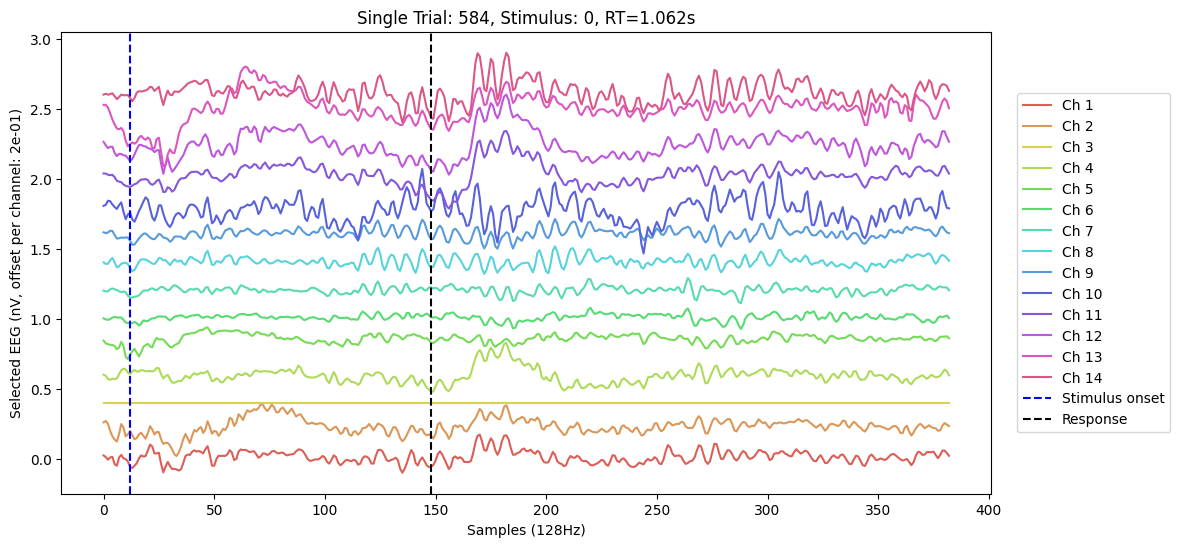

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

i=584
offset = 2e-1
epoch = X[i]   # shape (3*128, 14)
label = y[i]
rt = RT[i]     # reaction time in seconds

# convert RT to sample index (relative to stimulus onset at sample=pre)
rt_sample = int(pre + rt * 128) if rt is not None else None

plt.figure(figsize=(12, 6))
color_list = sns.color_palette("hls", n_colors=14)
for ch in range(epoch.shape[1]):
    plt.plot(epoch[:, ch] + ch*offset, label=f"Ch {ch+1}", c=color_list[ch])  # offset per channel

# stimulus onset at sample=pre (26)
plt.axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

# response line if available
if rt_sample is not None and rt_sample < len(epoch):
    plt.axvline(x=rt_sample, color="black", linestyle="--", label="Response")

plt.title(f"Single Trial: {i}, Stimulus: {label}, RT={rt:.3f}s")
plt.xlabel("Samples (128Hz)")
plt.ylabel(f"Selected EEG (nV, offset per channel: {offset:.0e})")
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.show()

# Train-test split

In [ ]:
# Reshape raw data for Keras
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (576, 383, 14)
X_test shape: (180, 383, 14)
X_val shape: (144, 383, 14)


In [ ]:
from sklearn.preprocessing import LabelEncoder
# One-hot encode labels
num_classes = len(np.unique(y))
encoder = LabelEncoder()
encoder.fit(y)

LabelEncoder()

# Model: CNN

In [ ]:
# def get_model(input_shape, num_classes):
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.Conv1D(32, kernel_size=3, activation="relu", input_shape=(input_shape)),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Conv1D(64, kernel_size=3, activation="relu"),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(64, activation="relu"),
#         tf.keras.layers.Dropout(0.1),  # regularization to improve generalization
#         tf.keras.layers.Dense(num_classes, activation="softmax")
# ])
#     return model

# model = get_model((X_train.shape[1], X_train.shape[2]), num_classes)
# model.summary()

In [ ]:
def get_model_reg(input_shape, num_classes): # add regularizers
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(32, kernel_size=5, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4), input_shape=(input_shape)),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(64, kernel_size=5, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.Dropout(0.1),  # regularization to improve generalization
            tf.keras.layers.Dense(num_classes, activation="softmax")
        ])
    return model

model = get_model_reg((X_train.shape[1], X_train.shape[2]), num_classes)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 379, 32)        │         2,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 189, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 185, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 5888)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       376,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,667 (1.49 MB)

 Trainable params: 389,667 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

# Model: LSTM
Same as CNN, just with LSTM (100 cells) instead of flatten

In [ ]:
def get_model_lstm(input_shape, num_classes):
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(32, kernel_size=5, activation="relu", input_shape=(input_shape)),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(64, kernel_size=5, activation="relu"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.LSTM(units=100, activation="tanh", return_sequences=False),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.1),  # regularization to improve generalization
            tf.keras.layers.Dense(num_classes, activation="softmax")
        ])
    return model

model = get_model_lstm((X_train.shape[1], X_train.shape[2]), num_classes)
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)              │ (None, 379, 32)        │         2,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_54 (MaxPooling1D) │ (None, 189, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 185, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_55 (MaxPooling1D) │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,235 (332.95 KB)

 Trainable params: 85,235 (332.95 KB)

 Non-trainable params: 0 (0.00 B)

# DL Pipeline: EEG matrix

In [ ]:
def get_callbacks(chckpt_path = model_path+"model.keras"):
    cp = tf.keras.callbacks.ModelCheckpoint(chckpt_path, save_best_only=True, monitor="val_accuracy", mode="max")
    es  = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)
    rlr  = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.8, patience=5, min_lr=1e-6)
    return cp, es, rlr

In [ ]:
def get_metrics(y_test, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    return acc, prec, rec, f1

In [ ]:
results = []

In [ ]:
# One-hot encode labels
y_train = encoder.transform(y_train)
y_val   = encoder.transform(y_val)
y_test  = encoder.transform(y_test)

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat   = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test, num_classes)

# CNN Model
model = get_model_lstm((X_train.shape[1], X_train.shape[2]), num_classes)
model.compile(optimizer="adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=["accuracy"])

# === Callbacks ===
chckpt_path = model_path+"best_lstm.keras"
checkpoint_cb, earlystop_cb, reduce_lr_cb = get_callbacks(chckpt_path)

# Train
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

# Load best model
model_ = tf.keras.models.load_model(chckpt_path)

# Evaluate
test_loss, test_acc = model_.evaluate(X_test, y_test_cat, verbose=0)
print(f"No Aug. LSTM Test Accuracy: {test_acc:.2f}")

y_pred = np.argmax(model_.predict(X_test), axis=1)
acc, prec, rec, f1 = get_metrics(y_test, y_pred)

results.append({
            "Input": "X",
            "Augmentation": "None",
            "Train_shape": X_train.shape,
            "Model": "LSTM",
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        })

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.3652 - loss: 1.1004 - val_accuracy: 0.2639 - val_loss: 1.1048 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3319 - loss: 1.0984 - val_accuracy: 0.2708 - val_loss: 1.1070 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.3867 - loss: 1.0930 - val_accuracy: 0.2917 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.3547 - loss: 1.0908 - val_accuracy: 0.3333 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.3781 - loss: 1.0883 - val_accuracy: 0.3472 - val_loss: 1.0957 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3667 - loss: 1.0938 - val_accuracy: 0.3333 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4074 - loss: 1.0845 - val_acc

# Data Augmentation Setup

In [ ]:
def augment_eeg(X, y, aug_type, perc=0.3, noise_std=0.01, seed=None):
    """
    Apply data augmentation to EEG trials.

    Parameters
    ----------
    X : np.ndarray
        Shape (n_trials, time, channels).
    y : np.ndarray
        Labels (n_trials,).
    perc : float
        Fraction of data to augment (0.0–1.0).
    noise_std : float
        Standard deviation of Gaussian noise (relative to signal).
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    X_aug, y_aug : np.ndarray
        Augmented dataset (original + augmented).
    """
    rng = np.random.default_rng(seed)
    n_trials = X.shape[0]
    n_aug = int(n_trials * perc)

    # indices to augment
    idxs = rng.choice(n_trials, size=n_aug, replace=False)

    X_new, y_new = [], []

    for idx in idxs:
        trial = X[idx].copy()

        if aug_type == 0:
            # Reverse in time
            trial = trial[::-1, :]

        elif aug_type == 1:
            # Shuffle channels
            perm = rng.permutation(trial.shape[1])
            trial = trial[:, perm]

        elif aug_type == 2:
            # Add Gaussian noise
            sigma = noise_std * np.std(trial)
            trial = trial + rng.normal(0, sigma, size=trial.shape)

        elif aug_type == 3:
            # Randomly drop one channel (set to zero)
            drop = rng.choice(n_channels, size=1, replace=False)
            trial[:, drop] = 0.0

        X_new.append(trial)
        y_new.append(y[idx])

    # stack augmented data with original
    X_aug = np.concatenate([X, np.array(X_new)], axis=0)
    y_aug = np.concatenate([y, np.array(y_new)], axis=0)

    return X_aug, y_aug

# Reversed Augmentation

In [ ]:
aug_type = 0 # 0=reverse, 1=shuffle channels, 2=add noise, 3=drop a channel
X_rev, y_rev = augment_eeg(X_train, y_train,
                           aug_type,
                           perc=0.4,
                           noise_std=0.02,
                           seed=42)
print("Original:", X_train.shape, "Augmented:", X_rev.shape)

Original: (576, 383, 14) Augmented: (806, 383, 14)


In [ ]:
# One-hot encode labels
y_rev = encoder.transform(y_rev)
y_rev_cat = tf.keras.utils.to_categorical(y_rev, num_classes)

# CNN Model
model = get_model_lstm((X_rev.shape[1], X_rev.shape[2]), num_classes)
model.compile(optimizer="adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=["accuracy"])

# === Callbacks ===
chckpt_path = model_path+"best_lstm_rev.keras"
checkpoint_cb, earlystop_cb, reduce_lr_cb = get_callbacks(chckpt_path)

# Train
history = model.fit(
    X_rev, y_rev_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

# Load best model (optional if EarlyStopping restores weights)
model_ = tf.keras.models.load_model(chckpt_path)

# Evaluate
test_loss, test_acc = model_.evaluate(X_test, y_test_cat, verbose=0)
print(f"Reversed Aug. LSTM Test Accuracy: {test_acc:.2f}")

y_pred = np.argmax(model_.predict(X_test), axis=1)
acc, prec, rec, f1 = get_metrics(y_test, y_pred)

results.append({
            "Input": "X",
            "Augmentation": "Reversed",
            "Train_shape": X_rev.shape,
            "Model": "LSTM",
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        })

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.3344 - loss: 1.1006 - val_accuracy: 0.2639 - val_loss: 1.1021 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.3551 - loss: 1.0971 - val_accuracy: 0.2986 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4028 - loss: 1.0937 - val_accuracy: 0.3264 - val_loss: 1.1063 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4038 - loss: 1.0859 - val_accuracy: 0.3194 - val_loss: 1.1047 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3726 - loss: 1.0888 - val_accuracy: 0.3125 - val_loss: 1.1051 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4035 - loss: 1.0795 - val_accuracy: 0.2778 - val_loss: 1.1182 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.4099 - loss: 1.0749 - val_

# Channel Shuffle Augmentation

In [ ]:
aug_type = 1 # 0=reverse, 1=shuffle channels, 2=add noise, 3=drop a channel
X_shuf, y_shuf = augment_eeg(X_train, y_train,
                           aug_type,
                           perc=0.4,
                           noise_std=0.02,
                           seed=42)
print("Original:", X_train.shape, "Augmented:", X_shuf.shape)

Original: (576, 383, 14) Augmented: (806, 383, 14)


In [ ]:
# One-hot encode labels
y_shuf = encoder.transform(y_shuf)
y_shuf_cat = tf.keras.utils.to_categorical(y_shuf, num_classes)

# CNN Model
model = get_model_lstm((X_rev.shape[1], X_rev.shape[2]), num_classes)
model.compile(optimizer="adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=["accuracy"])

# === Callbacks ===
chckpt_path = model_path+"best_lstm_shuf.keras"
checkpoint_cb, earlystop_cb, reduce_lr_cb = get_callbacks(chckpt_path)

# Train
history = model.fit(
    X_shuf, y_shuf_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

# Load best model
model_ = tf.keras.models.load_model(chckpt_path)

# Evaluate
test_loss, test_acc = model_.evaluate(X_test, y_test_cat, verbose=0)
print(f"Shuffle Aug. LSTM Test Accuracy: {test_acc:.2f}")

y_pred = np.argmax(model_.predict(X_test), axis=1)
acc, prec, rec, f1 = get_metrics(y_test, y_pred)

results.append({
            "Input": "X",
            "Augmentation": "Shuffled",
            "Train_shape": X_shuf.shape,
            "Model": "LSTM",
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        })

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.3227 - loss: 1.1011 - val_accuracy: 0.3681 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.3819 - loss: 1.0970 - val_accuracy: 0.3819 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3479 - loss: 1.0950 - val_accuracy: 0.3264 - val_loss: 1.1081 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3864 - loss: 1.0891 - val_accuracy: 0.2986 - val_loss: 1.0999 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4243 - loss: 1.0830 - val_accuracy: 0.3056 - val_loss: 1.1117 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.4080 - loss: 1.0858 - val_accuracy: 0.3333 - val_loss: 1.1024 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.3716 - loss: 1.0818 - val_ac

# Noise Augmentation

In [ ]:
aug_type = 2 # 0=reverse, 1=shuffle channels, 2=add noise, 3=drop a channel
X_noisy, y_noisy = augment_eeg(X_train, y_train,
                           aug_type,
                           perc=0.4,
                           noise_std=0.02,
                           seed=42)
print("Original:", X_train.shape, "Augmented:", X_noisy.shape)

Original: (576, 383, 14) Augmented: (806, 383, 14)


In [ ]:
# One-hot encode labels
y_noisy = encoder.transform(y_noisy)
y_noisy_cat = tf.keras.utils.to_categorical(y_noisy, num_classes)

# CNN Model
model = get_model_lstm((X_noisy.shape[1], X_noisy.shape[2]), num_classes)
model.compile(optimizer="adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=["accuracy"])

# === Callbacks ===
chckpt_path = model_path+"best_lstm_nois.keras"
checkpoint_cb, earlystop_cb, reduce_lr_cb = get_callbacks(chckpt_path)

# Train
history = model.fit(
    X_noisy, y_noisy_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

# Load best model
model_ = tf.keras.models.load_model(chckpt_path)

# Evaluate
test_loss, test_acc = model_.evaluate(X_test, y_test_cat, verbose=0)
print(f"Noise Aug. LSTM Test Accuracy: {test_acc:.2f}")

y_pred = np.argmax(model_.predict(X_test), axis=1)
acc, prec, rec, f1 = get_metrics(y_test, y_pred)

results.append({
            "Input": "X",
            "Augmentation": "Noise",
            "Train_shape": X_noisy.shape,
            "Model": "LSTM",
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        })

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.3485 - loss: 1.0996 - val_accuracy: 0.3681 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.4022 - loss: 1.0943 - val_accuracy: 0.2569 - val_loss: 1.1043 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4410 - loss: 1.0848 - val_accuracy: 0.3125 - val_loss: 1.1015 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.4056 - loss: 1.0834 - val_accuracy: 0.3194 - val_loss: 1.1069 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.4097 - loss: 1.0766 - val_accuracy: 0.2847 - val_loss: 1.1405 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.4120 - loss: 1.0780 - val_accuracy: 0.3194 - val_loss: 1.1148 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4836 - loss: 1.0494 - val_ac

# Channel Drop Augmentation

In [ ]:
aug_type = 3 # 0=reverse, 1=shuffle channels, 2=add noise, 3=drop a channel
X_ch, y_ch = augment_eeg(X_train, y_train,
                           aug_type,
                           perc=0.4,
                           noise_std=0.02,
                           seed=42)
print("Original:", X_train.shape, "Augmented:", X_ch.shape)

Original: (576, 383, 14) Augmented: (806, 383, 14)


In [ ]:
# One-hot encode labels
y_ch = encoder.transform(y_ch)
y_ch_cat = tf.keras.utils.to_categorical(y_ch, num_classes)

# CNN Model
model = get_model_lstm((X_ch.shape[1], X_ch.shape[2]), num_classes)
model.compile(optimizer="adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=["accuracy"])

# === Callbacks ===
chckpt_path = model_path+"best_lstm_chdrop.keras"
checkpoint_cb, earlystop_cb, reduce_lr_cb = get_callbacks(chckpt_path)

# Train
history = model.fit(
    X_ch, y_ch_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

# Load best model (optional if EarlyStopping restores weights)
model_ = tf.keras.models.load_model(chckpt_path)

# Evaluate
test_loss, test_acc = model_.evaluate(X_test, y_test_cat, verbose=0)
print(f"Ch Drop Aug. LSTM Test Accuracy: {test_acc:.2f}")

y_pred = np.argmax(model_.predict(X_test), axis=1)
acc, prec, rec, f1 = get_metrics(y_test, y_pred)

results.append({
            "Input": "X",
            "Augmentation": "Ch_drop",
            "Train_shape": X_ch.shape,
            "Model": "LSTM",
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        })

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.3221 - loss: 1.1000 - val_accuracy: 0.2431 - val_loss: 1.0999 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4036 - loss: 1.0929 - val_accuracy: 0.3611 - val_loss: 1.0959 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3713 - loss: 1.0881 - val_accuracy: 0.2847 - val_loss: 1.1078 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.3732 - loss: 1.0900 - val_accuracy: 0.3542 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4063 - loss: 1.0829 - val_accuracy: 0.3264 - val_loss: 1.1018 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4034 - loss: 1.0729 - val_accuracy: 0.3750 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.4379 - loss: 1.0705 - val_acc

# See results

In [ ]:
df_results = pd.DataFrame(results)
df_results.style.highlight_max(color='yellow', subset=['Accuracy','Precision','Recall','F1'])

,index,Input,Augmentation,Train_shape,Model,Accuracy,Precision,Recall,F1
0,0,X,None,"(576, 383, 14)",CNN,0.372222,0.389507,0.372222,0.353575
1,1,X,Reversed,"(806, 383, 14)",CNN,0.411111,0.414380,0.411111,0.372738
2,2,X,Shuffled,"(806, 383, 14)",CNN,0.377778,0.379837,0.377778,0.378591
3,3,X,Noise,"(806, 383, 14)",CNN,0.400000,0.397301,0.400000,0.392548
4,5,X,Ch_drop,"(806, 383, 14)",CNN,0.344444,0.339947,0.344444,0.340532


In [ ]:
df_lstm_results = pd.DataFrame(results)
df_lstm_results.style.highlight_max(color='yellow', subset=['Accuracy','Precision','Recall','F1'])

,Input,Augmentation,Train_shape,Model,Accuracy,Precision,Recall,F1
0,X,None,"(576, 383, 14)",LSTM,0.344444,0.223686,0.344444,0.259240
1,X,Reversed,"(806, 383, 14)",LSTM,0.316667,0.316593,0.316667,0.316616
2,X,Shuffled,"(806, 383, 14)",LSTM,0.361111,0.360029,0.361111,0.353436
3,X,Noise,"(806, 383, 14)",LSTM,0.283333,0.284833,0.283333,0.283398
4,X,Ch_drop,"(806, 383, 14)",LSTM,0.311111,0.312968,0.311111,0.308262


In [ ]:
df = pd.concat([df_results, df_lstm_results], axis=0)

In [ ]:
df.style.highlight_max(color='yellow', subset=['Accuracy','Precision','Recall','F1'])

,Input,Augmentation,Train_shape,Model,Accuracy,Precision,Recall,F1
0,X,None,"(576, 383, 14)",CNN,0.372222,0.389507,0.372222,0.353575
1,X,Reversed,"(806, 383, 14)",CNN,0.411111,0.414380,0.411111,0.372738
2,X,Shuffled,"(806, 383, 14)",CNN,0.377778,0.379837,0.377778,0.378591
3,X,Noise,"(806, 383, 14)",CNN,0.400000,0.397301,0.400000,0.392548
4,X,Ch_drop,"(806, 383, 14)",CNN,0.344444,0.339947,0.344444,0.340532
5,X,None,"(576, 383, 14)",LSTM,0.344444,0.223686,0.344444,0.259240
6,X,Reversed,"(806, 383, 14)",LSTM,0.316667,0.316593,0.316667,0.316616
7,X,Shuffled,"(806, 383, 14)",LSTM,0.361111,0.360029,0.361111,0.353436
8,X,Noise,"(806, 383, 14)",LSTM,0.283333,0.284833,0.283333,0.283398
9,X,Ch_drop,"(806, 383, 14)",LSTM,0.311111,0.312968,0.311111,0.308262


In [ ]:
results_path = '/content/drive/MyDrive/wearable_eeg/Results/'
df.to_csv(results_path+"DL_DA_results.csv", index=False)

In [ ]:
df[['Input',	'Augmentation',	'Train_shape',	'Model',	'Accuracy',	'Precision',	'Recall',	'F1']].to_csv(results_path+"DL_DA_results.csv", index=False)

# Cross Validation (EEG matrix)

In [ ]:
n_trials_per_subj = 90
n_subj = 10
users = np.repeat(np.arange(n_subj), n_trials_per_subj)

In [ ]:
# Animals = 0, Fruits = 1, Tools = 2
encoder.classes_

array([0, 1, 2])

In [ ]:
# Verify the classes
tf.keras.utils.to_categorical([0,1,2], num_classes)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
# --- Setup ---
unique_users = np.unique(users)
# all_reports = []
# cv_results = []

# One-hot encoder for y
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(encoder.classes_)
class_names = ['Animals','Fruits','Tools'] # Assign class names

for test_user in unique_users:
    print(f"\n=== Leave out {test_user+1} ===")

    # Train/test/val split
    train_idx = users != test_user
    test_idx  = users == test_user

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Augmentation ONLY in train
    X_train, y_train = augment_eeg(X_train, y_train,
                              2, # 0=reverse, 1=shuffle channels, 2=add noise, 3=drop a channel
                              perc=0.4,
                              noise_std=0.02,
                              seed=42)

    # One-hot labels
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test_cat  = tf.keras.utils.to_categorical(y_test, num_classes)
    y_val_cat  = tf.keras.utils.to_categorical(y_val, num_classes)

    # --- CNN Model ---
    model = get_model_reg((X_train.shape[1], X_train.shape[2]), num_classes)
    model.compile(optimizer="adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=["accuracy"])

    # --- Callbacks ---
    chckpt_path = f"{model_path}Cross-Validation/best_cnn_noise_user{test_user+1}.keras"
    es, rlr, ckpt = get_callbacks(chckpt_path)

    # --- Train (use part of training as validation) ---
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=20,
        batch_size=16,
        callbacks=[es, rlr, ckpt],
        verbose=1
    )

    # --- Evaluate ---
    best_model = tf.keras.models.load_model(chckpt_path)
    y_pred_prob = best_model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    acc, prec, rec, f1 = get_metrics(y_test, y_pred)

    cv_results.append({
        "Input": "X",
        "Augmentation": "Noise",
        "Train_shape": X_train.shape,
        "Model": "CNN", # change accordingly
        "Test_user": test_user+1,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })


    report = classification_report(y_test, y_pred,
                                   digits=3,
                                   output_dict=True,
                                   target_names=class_names)

    print('\n',classification_report(y_test, y_pred, digits=3,target_names=class_names))
    all_reports.append(report)

# --- Average metrics across folds ---
df_reports = pd.DataFrame(all_reports)
print("\n=== Mean LOSO performance ===")
print(df_reports.mean(numeric_only=True))


=== Leave out 1 ===
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.3309 - loss: 1.1275 - val_accuracy: 0.2593 - val_loss: 1.1212 - learning_rate: 0.0010
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4048 - loss: 1.1004 - val_accuracy: 0.3086 - val_loss: 1.1206 - learning_rate: 0.0010
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4386 - loss: 1.0782 - val_accuracy: 0.3272 - val_loss: 1.1312 - learning_rate: 0.0010
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5678 - loss: 1.0066 - val_accuracy: 0.3333 - val_loss: 1.2211 - learning_rate: 0.0010
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6153 - loss: 0.9452 - val_accuracy: 0.2716 - val_loss: 1.3080 - learning_rate: 0.0010
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7101 - loss: 0.8023 - val_accuracy: 0.2716 - val_loss: 1.4301 - learning_rate: 0.0010
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7965 - l

**CNN+Reversed Augm.**
```
=== Mean LOSO performance ===
accuracy    0.313333
dtype: float64
```

**CNN+Noise Augm.**
```
=== Mean LOSO performance ===
accuracy    0.324444
dtype: float64
```



In [ ]:
df_cv_results = pd.DataFrame(cv_results)
df_cv_results

,Input,Augmentation,Train_shape,Model,Test_user,Accuracy,Precision,Recall,F1
0,X,Reversed,"(907, 383, 14)",CNN,1,0.300000,0.313051,0.300000,0.287468
1,X,Reversed,"(907, 383, 14)",CNN,2,0.344444,0.316141,0.344444,0.291231
2,X,Reversed,"(907, 383, 14)",CNN,3,0.288889,0.296350,0.288889,0.291494
3,X,Reversed,"(907, 383, 14)",CNN,4,0.333333,0.310367,0.333333,0.318854
4,X,Reversed,"(907, 383, 14)",CNN,5,0.366667,0.392182,0.366667,0.368221
5,X,Reversed,"(907, 383, 14)",CNN,6,0.288889,0.185556,0.288889,0.193651
6,X,Reversed,"(907, 383, 14)",CNN,7,0.355556,0.345811,0.355556,0.347756
7,X,Reversed,"(907, 383, 14)",CNN,8,0.255556,0.196618,0.255556,0.182828
8,X,Reversed,"(907, 383, 14)",CNN,9,0.300000,0.301587,0.300000,0.284013
9,X,Reversed,"(907, 383, 14)",CNN,10,0.300000,0.273037,0.300000,0.277750


In [ ]:
df_cv_results.to_csv(results_path+"DL_CV_results.csv", index=False)

# Cross Validation (EEG vector)

In [ ]:
X_reshaped = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X_reshaped.shape

(900, 5362)

In [ ]:
unique_users = np.unique(users)
all_reports = []

for test_user in unique_users:
    print(f"\n=== Leave out {test_user+1} ===")

    # Train/test split
    train_idx = users != test_user
    test_idx  = users == test_user

    X_train, X_test = X_reshaped[train_idx], X_reshaped[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standar Scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Classifier
    clf = LogisticRegression(C=0.1,max_iter=2000,
                             multi_class="multinomial",
                             solver="newton-cg",
                             penalty='l2')

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred, digits=3))
    all_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Average metrics across folds

df_reports = pd.DataFrame(all_reports)
print("\n=== Mean LOSO performance ===")
print(df_reports.mean(numeric_only=True))


=== Leave out 1 ===
              precision    recall  f1-score   support

           0      0.393     0.367     0.379        30
           1      0.375     0.400     0.387        30
           2      0.433     0.433     0.433        30

    accuracy                          0.400        90
   macro avg      0.400     0.400     0.400        90
weighted avg      0.400     0.400     0.400        90


=== Leave out 2 ===
              precision    recall  f1-score   support

           0      0.312     0.333     0.323        30
           1      0.207     0.200     0.203        30
           2      0.310     0.300     0.305        30

    accuracy                          0.278        90
   macro avg      0.277     0.278     0.277        90
weighted avg      0.277     0.278     0.277        90


=== Leave out 3 ===
              precision    recall  f1-score   support

           0      0.370     0.333     0.351        30
           1      0.241     0.233     0.237        30
           2

## CV per user

In [ ]:
def per_user_cv(X_feats, y, users, model=None, n_splits=5, corr_threshold=0.05, random_state=42):
    """
    X_feats: (n_trials, n_features)
    y: (n_trials,)
    users: (n_trials,) subject ids (strings or ints)
    model: sklearn estimator (if None -> LogisticRegression)
    n_splits: folds per user (StratifiedKFold)
    """
    if model is None:
        model = LogisticRegression(C=0.1,
                                   max_iter=2000,
                                   multi_class="multinomial",
                                   solver="newton-cg",
                                   penalty='l2')

    unique_users = np.unique(users)
    results = {}

    for user in unique_users:
        idx_user = (users == user)
        X_user = X_feats[idx_user]
        y_user = y[idx_user]
        n_samples = X_user.shape[0]
        print(f"\nUser {user+1}: {n_samples} trials")

        # if too few samples for k folds, reduce k or use LeaveOneOut
        k = min(n_splits, n_samples)
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

        fold_metrics = []
        fold_reports = []
        fold_cms = []

        fold_num = 0
        for train_i, test_i in skf.split(X_user, y_user):
            fold_num += 1
            X_tr, X_te = X_user[train_i], X_user[test_i]
            y_tr, y_te = y_user[train_i], y_user[test_i]

            # scale with train scaler
            scaler = StandardScaler()
            X_tr_scaled = scaler.fit_transform(X_tr)
            X_te_scaled = scaler.transform(X_te)

            # train model
            clf = model
            clf.fit(X_tr_scaled, y_tr)
            y_pred = clf.predict(X_te_scaled)

            acc = accuracy_score(y_te, y_pred)
            bal_acc = balanced_accuracy_score(y_te, y_pred)
            cm = confusion_matrix(y_te, y_pred)
            report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)

            fold_metrics.append({"accuracy": acc, "balanced_accuracy": bal_acc})
            fold_reports.append(report)
            fold_cms.append(cm)

            print(f" User {user+1} fold {fold_num} acc={acc:.3f} bal_acc={bal_acc:.3f}")

        # aggregate per-user results
        dfm = pd.DataFrame(fold_metrics)
        mean_metrics = dfm.mean().to_dict()
        results[user] = {
            "fold_metrics": fold_metrics,
            "mean_metrics": mean_metrics,
            "fold_reports": fold_reports,
            "fold_confusion_matrices": fold_cms
        }
        print(f" -> User {user+1} mean accuracy: {mean_metrics['accuracy']:.3f}, mean balanced: {mean_metrics['balanced_accuracy']:.3f}")

    return results

### Logistic Regression

In [ ]:
# LOGISTIC REGRESSION
rf = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight="balanced")
results = per_user_cv(X_reshaped, y, users, model=None, n_splits=5, corr_threshold=0.1)


User 1: 90 trials
 User 1 fold 1 acc=0.389 bal_acc=0.389
 User 1 fold 2 acc=0.167 bal_acc=0.167
 User 1 fold 3 acc=0.444 bal_acc=0.444
 User 1 fold 4 acc=0.278 bal_acc=0.278
 User 1 fold 5 acc=0.556 bal_acc=0.556
 -> User 1 mean accuracy: 0.367, mean balanced: 0.367

User 2: 90 trials
 User 2 fold 1 acc=0.556 bal_acc=0.556
 User 2 fold 2 acc=0.444 bal_acc=0.444
 User 2 fold 3 acc=0.278 bal_acc=0.278
 User 2 fold 4 acc=0.389 bal_acc=0.389
 User 2 fold 5 acc=0.389 bal_acc=0.389
 -> User 2 mean accuracy: 0.411, mean balanced: 0.411

User 3: 90 trials
 User 3 fold 1 acc=0.500 bal_acc=0.500
 User 3 fold 2 acc=0.278 bal_acc=0.278
 User 3 fold 3 acc=0.278 bal_acc=0.278
 User 3 fold 4 acc=0.278 bal_acc=0.278
 User 3 fold 5 acc=0.222 bal_acc=0.222
 -> User 3 mean accuracy: 0.311, mean balanced: 0.311

User 4: 90 trials
 User 4 fold 1 acc=0.389 bal_acc=0.389
 User 4 fold 2 acc=0.389 bal_acc=0.389
 User 4 fold 3 acc=0.222 bal_acc=0.222
 User 4 fold 4 acc=0.222 bal_acc=0.222
 User 4 fold 5 acc=0.

In [ ]:
bal_accs = [res["mean_metrics"]["balanced_accuracy"] for res in results.values()]

bal_accs = np.array(bal_accs)
print(f"Balanced Accuracy (across users): {bal_accs.mean():.3f} ± {bal_accs.std():.3f}")

Balanced Accuracy (across users): 0.351 ± 0.049


### Random Forest

In [ ]:
# RANDOM FOREST
rf = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight="balanced")
results = per_user_cv(X_reshaped, y, users, model=rf, n_splits=5, corr_threshold=0.1)


User 1: 90 trials
 User 1 fold 1 acc=0.389 bal_acc=0.389
 User 1 fold 2 acc=0.278 bal_acc=0.278
 User 1 fold 3 acc=0.556 bal_acc=0.556
 User 1 fold 4 acc=0.389 bal_acc=0.389
 User 1 fold 5 acc=0.444 bal_acc=0.444
 -> User 1 mean accuracy: 0.411, mean balanced: 0.411

User 2: 90 trials
 User 2 fold 1 acc=0.500 bal_acc=0.500
 User 2 fold 2 acc=0.278 bal_acc=0.278
 User 2 fold 3 acc=0.389 bal_acc=0.389
 User 2 fold 4 acc=0.444 bal_acc=0.444
 User 2 fold 5 acc=0.444 bal_acc=0.444
 -> User 2 mean accuracy: 0.411, mean balanced: 0.411

User 3: 90 trials
 User 3 fold 1 acc=0.500 bal_acc=0.500
 User 3 fold 2 acc=0.278 bal_acc=0.278
 User 3 fold 3 acc=0.333 bal_acc=0.333
 User 3 fold 4 acc=0.500 bal_acc=0.500
 User 3 fold 5 acc=0.278 bal_acc=0.278
 -> User 3 mean accuracy: 0.378, mean balanced: 0.378

User 4: 90 trials
 User 4 fold 1 acc=0.444 bal_acc=0.444
 User 4 fold 2 acc=0.444 bal_acc=0.444
 User 4 fold 3 acc=0.444 bal_acc=0.444
 User 4 fold 4 acc=0.333 bal_acc=0.333
 User 4 fold 5 acc=0.

In [ ]:
bal_accs = [res["mean_metrics"]["balanced_accuracy"] for res in results.values()]
bal_accs = np.array(bal_accs)
print(f"Balanced Accuracy (across users): {bal_accs.mean():.3f} ± {bal_accs.std():.3f}")

Balanced Accuracy (across users): 0.374 ± 0.039
